# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [15, 3]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold

import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

import itertools      # today, we'll use this

Populating the interactive namespace from numpy and matplotlib


## 4. Regularization through predictor/feature selection (Lasso etc.)

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. **Regularization through predictor/feature selection (Lasso etc.)**

1. Resampling methods, and model selection

1. Decision trees, bagging, and random forests

1. Single-layer neural networks

Load data per previous classes ...

In [2]:
df = uci_files.standard_uci_data_access()

2020-05-12 13:46:45,055 INFO:Loading c:\Users\user\Desktop\Oxford\MFE\Advances in Machine Learning\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-05-12 13:46:50,794 INFO:Loaded c:\Users\user\Desktop\Oxford\MFE\Advances in Machine Learning\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [3]:
invalids = stock_codes.invalid_series(df)

In [4]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)
#  We build some additional columns in our dataframe to take logs etc.:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

2020-05-12 13:46:51,534 INFO:NumExpr defaulting to 8 threads.


In [5]:
# set out `y` and `X` variables:
predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']
y = invoices.log_item_spend
X = invoices[predictors]

In [6]:
print(f"We want prediction errors less than the original MSE of the y-variable, namely {y.var():2.4}")

We want prediction errors less than the original MSE of the y-variable, namely 0.4097


### **In this class**, we'll 

* replicate the dangerous overfitting of our OLS Polynomial Regression on our dataset;

* implement various regularizations that can fix it, and compare;

* a consequence of these will be that we *keep only a subset of our predictors*;

* we're left with an open practical question about 'tuning', and we preview how we could solve that.

#### First, we develop the overfitting predicament

Lets do 25 folds

In [7]:
N_FOLDS = 25

We prepare the polynomial expansion of the X-variables:

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4, include_bias=False)
polynomial_X = pd.DataFrame(poly.fit_transform(X.values))
polynomial_X.columns = poly.get_feature_names(X.columns)

To assist with matrix inversion, we standardize:

(there will be other advantages to doing this, for later steps)

In [9]:
poly_std_X = ((polynomial_X - polynomial_X.mean()) / polynomial_X.std())

In [10]:
poly_std_X.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
log_n_codes,20577.0,0.0,1.0,-2.05,-0.60,0.14,0.64,3.21
hour,20577.0,0.0,1.0,-2.38,-0.71,0.12,0.54,3.04
month,20577.0,-0.0,1.0,-3.34,0.14,0.30,0.41,0.49
words_per_item,20577.0,-0.0,1.0,-2.74,-0.69,-0.12,0.49,5.90
log_n_codes^2,20577.0,0.0,1.0,-1.32,-0.79,-0.11,0.52,5.70
...,...,...,...,...,...,...,...,...
month^4,20577.0,0.0,1.0,-3.34,0.14,0.30,0.41,0.49
month^3 words_per_item,20577.0,0.0,1.0,-2.74,-0.69,-0.12,0.49,5.90
month^2 words_per_item^2,20577.0,0.0,1.0,-1.62,-0.66,-0.22,0.33,9.05
month words_per_item^3,20577.0,-0.0,1.0,-1.02,-0.58,-0.27,0.17,13.38


We'll use again the function [`sbs_sklearn.train_n_test`](https://github.com/jeremy-large/ox-sbs-ml-bd/blob/master/lib/sbs_sklearn.py#L21)

In [11]:
sbs_sklearn.train_n_test?

Signature:
sbs_sklearn.train_n_test(
    X,
    y,
    n_folds,
    update_frequency=None,
    model=None,
    metric=None,
    train_on_minority=False,
    concise=True,
)
Docstring:
@param X: a pandas DataFrame of features data of shape (A, B)
@param y: a pandas Series of target data, of length A
@param n_folds: the number of splits, or folds, of the data that we would like performed
@param update_frequency: after implementing this many folds, provide an update
@param model: by default LinearRegression(). Can also be set to another model with methods .fit() and .predict()
@param metric: by default metrics.mean_squared_error. Can also be set to another metric
@param train_on_minority: if set to True, then reverse the roles of test and train
@return : a list of floats, each is the test MSE from a fold of the data
File:      c:\users\user\desktop\oxford\mfe\advances in machine learning\ox-sbs-ml-bd\lib\sbs_sklearn.py
Type:      function


#### The test MSE of the OLS regression exceeds the MSE of the $Y$-variable by ~30%:


2020-05-12 13:47:13,022 INFO:Study 1/25: 824 train rows;  19753 test rows


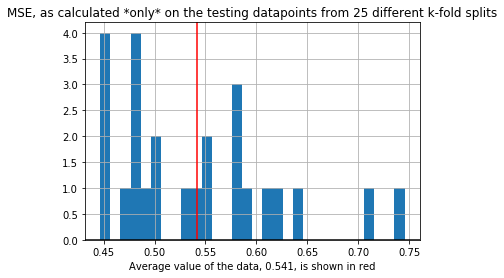

In [12]:
ols = linear_model.LinearRegression()   # << standard LinearRegression()
scores = sbs_sklearn.train_n_test(poly_std_X, y, N_FOLDS, train_on_minority=True, 
                                  model=ols )  # << standard LinearRegression()
sbs_sklearn.plot_kfold_scores(scores)

This is arguably worse than useless. Lets take a look at the fitted coefficients ...

In [13]:
def plot_coeffs(mod, mod_name, comment):
    plt.plot(mod.coef_, marker='o')
    plt.grid()
    plt.title(f"The betas of the {mod_name} - {comment}")
    plt.axhline(color='k')

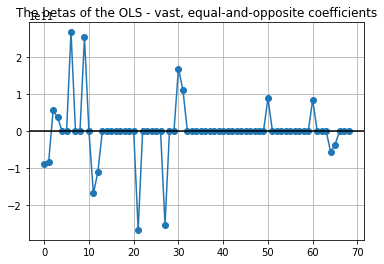

In [14]:
plot_coeffs(ols, 'OLS', 'vast, equal-and-opposite coefficients')

This is neither simple, nor interpretable. While it may hit closely the training data, 
* it's hard to believe it would generalise. 
* And we saw that it didn't generalise.

So, lets move towards regularization, beginning with [scikit-learn's Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

**Exercise** : every time we rerun the last couple of cells, we get different results. Where is this randomness coming from?

Now swap in the [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html):

In [15]:
ridge = linear_model.Ridge(alpha=25) # << ridge regression deployed here

(by the way, I picked alpha, $\alpha$, by a process of trial and error ...)

Now swap in the [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html):

2020-05-12 13:47:23,795 INFO:Study 1/25: 824 train rows;  19753 test rows


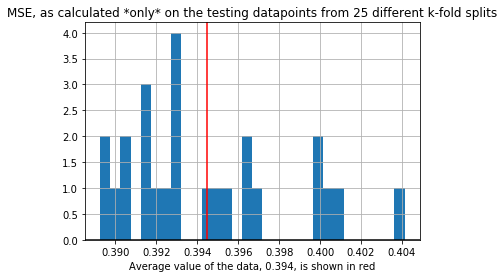

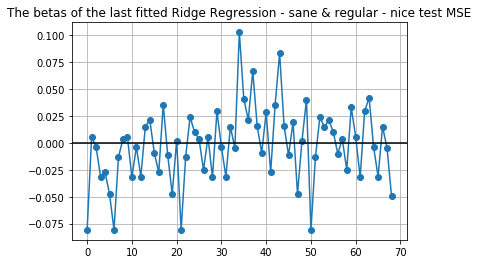

In [16]:
scores = sbs_sklearn.train_n_test(poly_std_X, y, N_FOLDS, train_on_minority=True, model=ridge)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(ridge, 'last fitted Ridge Regression', 'sane & regular - nice test MSE')

... easy to try the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) instead:

In [17]:
lasso = linear_model.Lasso(alpha=25 / (len(y) / N_FOLDS) / 2) # << Lasso here

(technical scikit-learn note: this is actually the same $\alpha$ as [`Ridge()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), bearing mind that `Lasso()` interprets the option `alpha=` differently)

... easy to try the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) instead:

2020-05-12 13:47:31,366 INFO:Study 1/25: 824 train rows;  19753 test rows


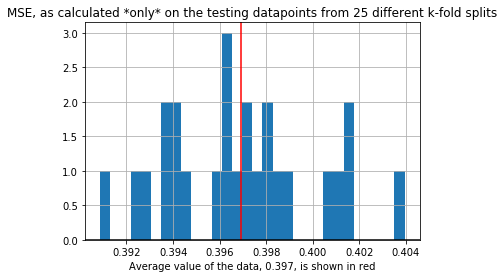

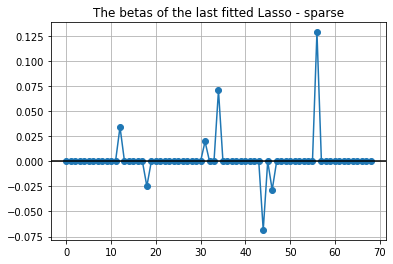

In [18]:
scores = sbs_sklearn.train_n_test(poly_std_X, y, N_FOLDS, train_on_minority=True, model=lasso)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(lasso, 'last fitted Lasso', 'sparse')

In [19]:
# so, which of the 69 predictors did Lasso keep?
for f in poly_std_X.columns[np.abs(lasso.coef_) > 0.0005]:
    print(f)

month words_per_item
log_n_codes hour^2
month^2 words_per_item
log_n_codes^4
log_n_codes hour^3
log_n_codes hour^2 words_per_item
hour^3 words_per_item


Finally, lets look at [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html):

(more trial-and-error in picking alpha, $\alpha$)

In [20]:
elastic = linear_model.ElasticNet( # << Elastic Net here
                                  alpha=25 / (len(y) / N_FOLDS) / 2,   # alpha parameter
                                  l1_ratio=0.33                        # how to distribute the parameter between l1 and l2 norms
                                 )

Finally, lets look at [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html):

2020-05-12 13:47:38,949 INFO:Study 1/25: 824 train rows;  19753 test rows


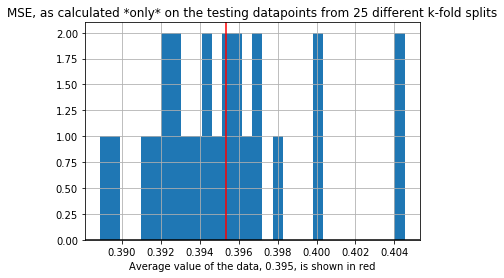

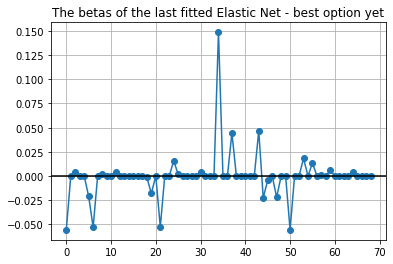

In [21]:
scores = sbs_sklearn.train_n_test(poly_std_X, y, N_FOLDS, train_on_minority=True, model=elastic)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(elastic, 'last fitted Elastic Net', 'best option yet')

In [22]:
# Ideally, of course, we'd be able to interpret the non-zero coefficients !?:
for i, c in enumerate(elastic.coef_):
    if np.abs(c) > 0.0005:
        print(sign(c), '  ', poly_std_X.columns[i])

-1.0    log_n_codes
1.0    month
-1.0    log_n_codes hour
-1.0    log_n_codes month
1.0    hour^2
1.0    month^2
-1.0    log_n_codes hour^2
-1.0    log_n_codes hour month
-1.0    log_n_codes month^2
1.0    hour^3
1.0    hour^2 month
1.0    month^3
1.0    log_n_codes^4
1.0    log_n_codes^3 words_per_item
1.0    log_n_codes^2 words_per_item^2
-1.0    log_n_codes hour^3
-1.0    log_n_codes hour^2 month
-1.0    log_n_codes hour month^2
-1.0    log_n_codes month^3
1.0    log_n_codes words_per_item^3
1.0    hour^3 month
1.0    hour^2 month^2
1.0    hour^2 words_per_item^2
1.0    month^4


[Here](https://scikit-learn.org/stable/modules/linear_model.html#)'s an overview of several of the ideas in this class, plus some others including [LARS Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lars-lasso), another numerical approach for estimating the Lasso.

**Exercise**: 

This is an exercise about varying the tuning parameter $\alpha$ in the Lasso. 

1. Read up on how to use the LARS Lasso at the link just above.

2. Now adapt the code [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html#sphx-glr-auto-examples-linear-model-plot-lasso-lars-py) to the current data, notebook and circumstances.

3. In a new box, change the x-axis so that it shows `np.log(alpha)`.

4. Interpret this diagram.

In [23]:
print(f'  - reminder: the log of the alpha we (=I) picked for the Lasso was {np.log(lasso.alpha):2.3}')

- reminder: the log of the alpha we (=I) picked for the Lasso was -4.19


In [32]:
poly_std_X.head()

,log_n_codes,hour,month,words_per_item,log_n_codes^2,log_n_codes hour,log_n_codes month,log_n_codes words_per_item,hour^2,hour month,...,hour^2 words_per_item^2,hour month^3,hour month^2 words_per_item,hour month words_per_item^2,hour words_per_item^3,month^4,month^3 words_per_item,month^2 words_per_item^2,month words_per_item^3,words_per_item^4
0,-0.369473,-2.379464,-3.344047,0.635705,-0.603204,-1.014078,-0.370202,0.126033,-1.887946,-2.380789,...,-0.856752,-2.383433,-1.075210,-0.475181,-0.279503,-3.344012,0.630093,0.479931,0.308057,0.151618
1,-0.929239,-2.379464,-3.344047,1.086827,-1.000717,-1.290140,-0.929724,-0.524595,-1.887946,-2.380789,...,-0.744358,-2.383433,-0.872896,-0.227391,-0.035762,-3.344012,1.080661,0.961088,0.768614,0.549521
2,0.329075,-1.546157,-3.344047,0.263727,0.115887,-0.334518,0.328041,0.852527,-1.377375,-1.547821,...,-0.658883,-1.551145,-0.730921,-0.388946,-0.290876,-3.344012,0.258572,0.118789,-0.006560,-0.095736
3,0.483366,-1.546157,-3.344047,-0.116165,0.308102,-0.236686,0.482264,0.736082,-1.377375,-1.547821,...,-0.788478,-1.551145,-0.949968,-0.611166,-0.471938,-3.344012,-0.120853,-0.216825,-0.272655,-0.286169
4,0.239252,-1.546157,-3.344047,-1.036100,0.009549,-0.391473,0.238257,-0.267358,-1.377375,-1.547821,...,-1.048612,-1.551145,-1.480405,-1.057226,-0.775094,-3.344012,-1.039658,-0.890500,-0.718185,-0.553755


In [33]:
y.head()

Invoice
489434    1.113165
489435    0.887891
489436    1.183553
489437    0.762255
489438    1.018069
Name: log_item_spend, dtype: float64

.

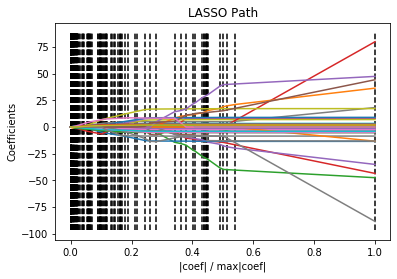

In [37]:
# Exercise

_, _, coefs = linear_model.lars_path(poly_std_X.values, y.values, method='lasso', verbose=True) #need numpy arrays not dataframes

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

#### Open question: how to pick the tuning parameter?

Recall, we have *parameters*, and we have *tuning parameters*: here, for example, `alpha` and `l1_ratio`

I picked tuning parameters by a process of trial and error.


Even tuning parameters can suffer from overfit: I probably overfitted them!

How can we save effort & self-doubt, and be more systematic?

#### Central Proposal: 

**tune**, by using comparing alternatives' test performance in k-fold splits (i.e. test/train splits)

* Known as **Cross-Validation**

* Do systematically, just what I was doing manually, to find a suitable $\alpha$ for Lasso and Ridge

* Should feel fairly familiar since we've now applied `sklearn.model_selection.KFold()` several times

#### **Cross-Validation** is a form of **Model Selection**
* *Introduction to Statistical Learning* Ch. 5

Difficulties of cross-validation:

1. Randomness in K-Fold 

1. What should the K in K-Fold be set to? 

    * Quick/easier to use a small K like 5 or 10. But
    
        * doesn't this exacerbates the randomness?
        
        * won't we tune $\alpha$ to an unrealistic case with fewer samples than in reality?

Next class - lets try this out and move on from Cross-Validation to related techniques in Subsampling.